#### Analyzing Neural Time Series Data
Python code for Chapter 12 -- converted from original Matlab by AE Studio (and ChatGPT)\
Original Matlab code by Mike X Cohen

This code accompanies the book, titled "Analyzing Neural Time Series Data" (MIT Press).\
Using the code without following the book may lead to confusion, incorrect data analyses, and misinterpretations of results.\
Mike X Cohen and AE Studio assume no responsibility for inappropriate or incorrect use of this code.

In [2]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.signal import hilbert, firwin, filtfilt
from scipy.fft import fft, ifft

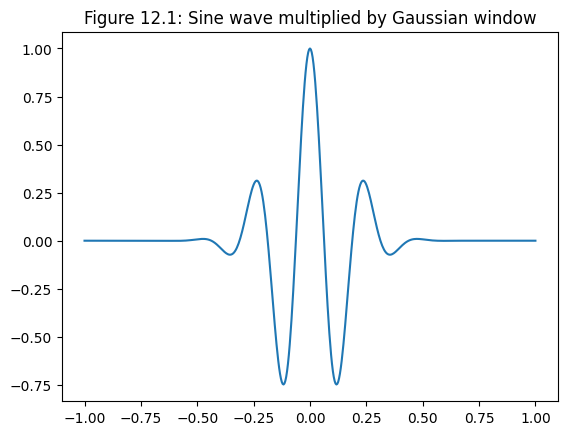

In [3]:
# Load sample EEG data
EEG = loadmat('../data/sampleEEGdata.mat')['EEG'][0,0]

# Define time and frequency for the sine wave
time = np.arange(-1, 1 + 1/EEG['srate'], 1/EEG['srate'])
f = 4  # frequency of sine wave in Hz

# Create sine wave (actually, a cosine wave)
sine_wave = np.cos(2 * np.pi * f * time)

# Make a Gaussian
s = 4 / (2 * np.pi * f)
gaussian_win = np.exp(-time**2 / (2 * s**2))

# Plot the sine wave multiplied by the Gaussian window
plt.figure()
plt.plot(time, sine_wave * gaussian_win)
plt.title('Figure 12.1: Sine wave multiplied by Gaussian window')
plt.show()

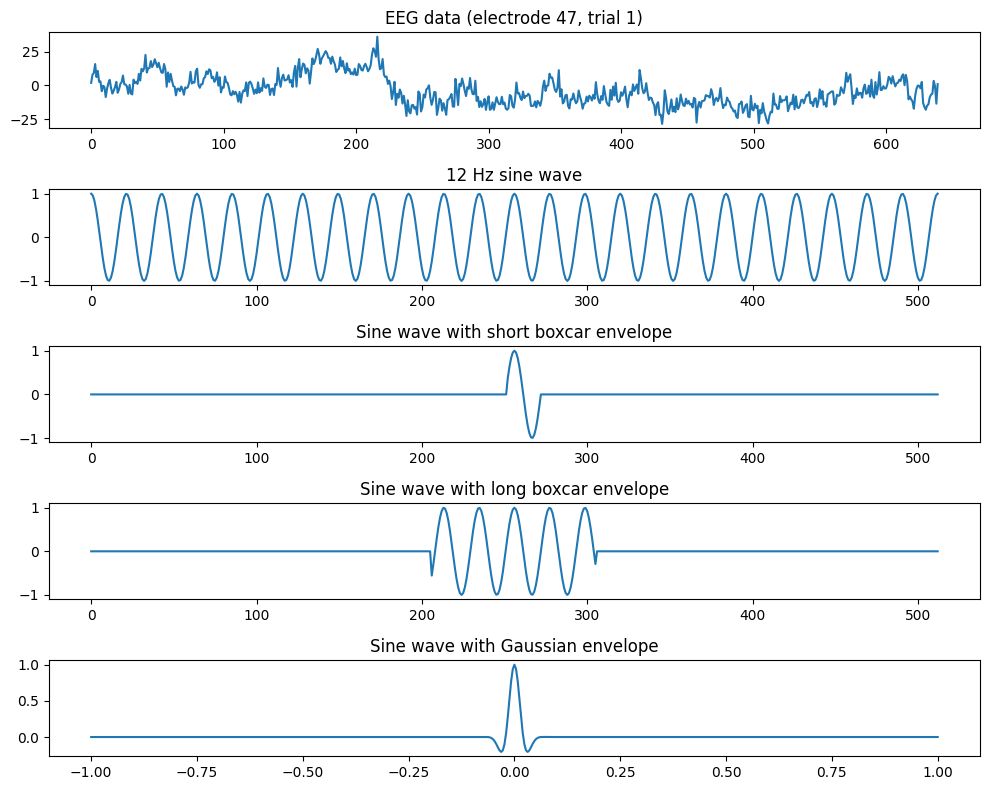

In [4]:
# Plotting EEG data and sine waves with different envelopes
plt.figure(figsize=(10, 8))

# Plot EEG data from one electrode and one trial
plt.subplot(511)
plt.plot(np.squeeze(EEG['data'][46,:,0]))
plt.axis('tight')
plt.title('EEG data (electrode 47, trial 1)')

# Plot sine wave at 12 Hz
plt.subplot(512)
sine_wave = np.cos(2 * np.pi * 12 * time)
plt.plot(sine_wave)
plt.axis('tight')
plt.title('12 Hz sine wave')

# Plot sine wave with boxcar envelope (short duration)
plt.subplot(513)
boxcar = np.zeros_like(sine_wave)
midpoint = (len(time) - 1) // 2
boxcar[midpoint - round(EEG['srate'][0,0] / 12 / 5):midpoint + round(EEG['srate'][0,0] / 12 / 1.25)] = 1
plt.plot(sine_wave * boxcar)
plt.axis('tight')
plt.title('Sine wave with short boxcar envelope')

# Plot sine wave with boxcar envelope (long duration)
plt.subplot(514)
boxcar = np.zeros_like(sine_wave)
boxcar[midpoint - 50:midpoint + 50] = 1
plt.plot(sine_wave * boxcar)
plt.axis('tight')
plt.title('Sine wave with long boxcar envelope')

# Plot sine wave with Gaussian envelope
plt.subplot(515)
s = 1.5 / (2 * np.pi * 12)
gaussian_win = np.exp(-time**2 / (2 * s**2))
plt.plot(time, sine_wave * gaussian_win)
plt.axis('tight')
plt.title('Sine wave with Gaussian envelope')

plt.tight_layout()
plt.show()

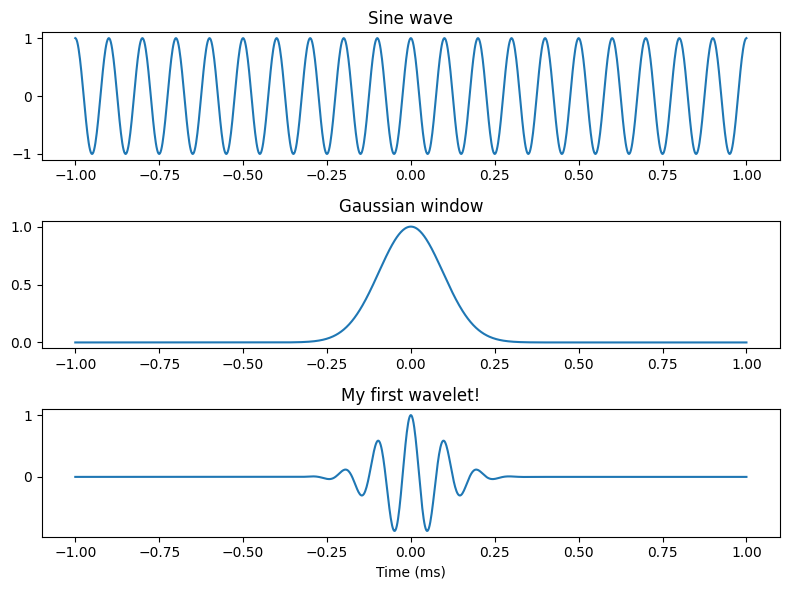

In [5]:
# Create a complex wavelet and plot its components
srate = 500  # sampling rate in Hz
f = 10  # frequency of the sine wave in Hz
time = np.arange(-1, 1 + 1/srate, 1/srate)  # time vector

# Create a complex sine wave (wavelet)
sine_wave = np.exp(2 * np.pi * 1j * f * time)

# Make a Gaussian
s = 6 / (2 * np.pi * f)
gaussian_win = np.exp(-time**2 / (2 * s**2))

# Combine sine wave and Gaussian to create a wavelet
wavelet = sine_wave * gaussian_win

# Plot each component and the wavelet
plt.figure(figsize=(8, 6))

plt.subplot(311)
plt.plot(time, np.real(sine_wave))
plt.title('Sine wave')

plt.subplot(312)
plt.plot(time, gaussian_win)
plt.title('Gaussian window')

plt.subplot(313)
plt.plot(time, np.real(wavelet))
plt.title('My first wavelet!')
plt.xlabel('Time (ms)')

plt.tight_layout()
plt.show()

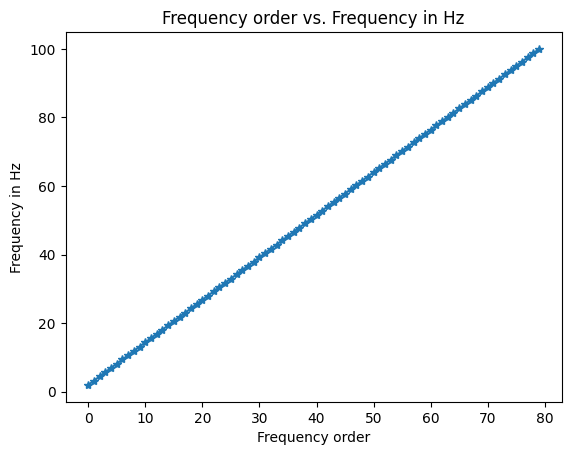

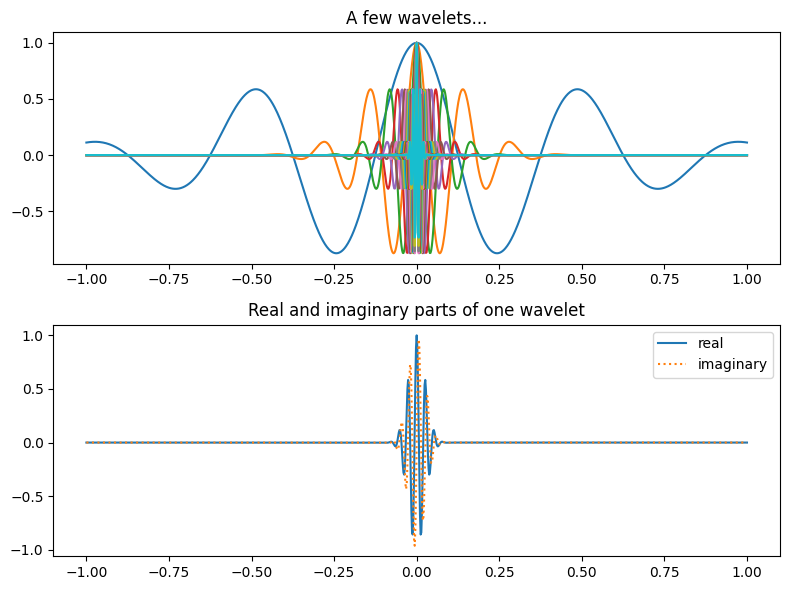

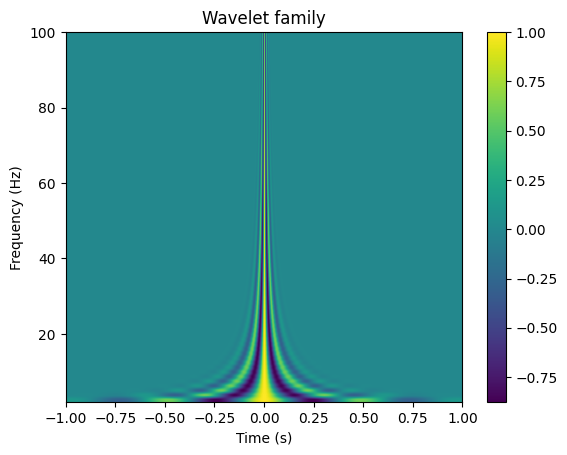

In [6]:
# Create a family of wavelets
num_wavelets = 80
lowest_frequency = 2
highest_frequency = 100

# Define frequencies
frequencies = np.linspace(lowest_frequency, highest_frequency, num_wavelets)

# Initialize wavelet family
wavelet_family = np.zeros((num_wavelets, len(time)), dtype=complex)

# Loop through frequencies and create wavelets
for fi in range(num_wavelets):
    sinewave = np.exp(2 * 1j * np.pi * frequencies[fi] * time)
    gaus_win = np.exp(-time**2 / (2 * (6 / (2 * np.pi * frequencies[fi]))**2))
    wavelet_family[fi, :] = sinewave * gaus_win

# Plot frequency order vs. frequency in Hz
plt.figure()
plt.plot(frequencies, '-*')
plt.xlabel('Frequency order')
plt.ylabel('Frequency in Hz')
plt.title('Frequency order vs. Frequency in Hz')
plt.show()

# Plot a few wavelets
plt.figure(figsize=(8, 6))

plt.subplot(211)
plt.plot(time, np.real(wavelet_family[::round(np.random.rand() * 30), :]).T)
plt.title('A few wavelets...')

plt.subplot(212)
plt.plot(time, np.real(wavelet_family[29, :]))
plt.plot(time, np.imag(wavelet_family[29, :]), ':')
plt.title('Real and imaginary parts of one wavelet')
plt.legend(['real', 'imaginary'])

plt.tight_layout()
plt.show()

# Image the wavelet family
plt.figure()
plt.imshow(np.real(wavelet_family), aspect='auto', extent=[time[0], time[-1], frequencies[0], frequencies[-1]], origin='lower')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Wavelet family')
plt.colorbar()
plt.show()

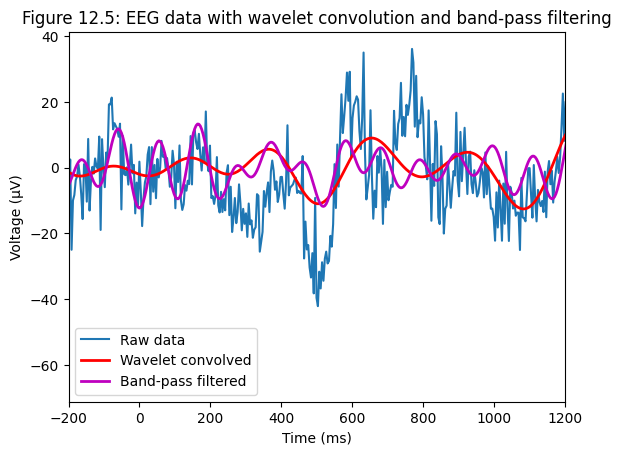

In [10]:
# EEG data from one trial (electrode FCz)
eegdata = np.squeeze(EEG['data'][46,:,9])

# Create wavelet
f = 6  # frequency of sine wave in Hz
sine_wave = np.exp(1j * 2 * np.pi * f * time)
s = 4.5 / (2 * np.pi * f)
gaussian_win = np.exp(-time**2 / (2 * s**2))
wavelet = sine_wave * gaussian_win
halfwaveletsize = int(np.ceil(len(wavelet) / 2))

# Convolve with data
n_conv = len(wavelet) + EEG['pnts'][0, 0] - 1
fft_w = fft(wavelet, n_conv)
fft_e = fft(eegdata, n_conv)
ift = ifft(fft_e * fft_w, n_conv) * np.sqrt(s) / 10  # empirical scaling factor
wavelet_conv_data = np.real(ift[halfwaveletsize-1:-halfwaveletsize+1])

# Create filter and apply to data
nyquist = EEG['srate'][0, 0] / 2
transition_width = 0.2  # percent
filter_low = 4  # Hz
filter_high = 8  # Hz
ffrequencies = [filter_low * (1 - transition_width), filter_low, filter_high, filter_high * (1 + transition_width)] / nyquist
idealresponse = [0, 1, 1, 0]
filterweights = firwin(round(3 * (EEG['srate'][0, 0] / filter_low)), ffrequencies, pass_zero=False, window='hamming')
eeg_4to8 = filtfilt(filterweights, 1, eegdata)

# Plot raw data, wavelet convolved data, and band-pass filtered data
plt.figure()
plt.plot(EEG['times'][0], eegdata)
plt.plot(EEG['times'][0], wavelet_conv_data, 'r', linewidth=2)
plt.plot(EEG['times'][0], eeg_4to8, 'm', linewidth=2)
plt.xlim([-200, 1200])
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (µV)')
plt.legend(['Raw data', 'Wavelet convolved', 'Band-pass filtered'])
plt.title('Figure 12.5: EEG data with wavelet convolution and band-pass filtering')
plt.show()

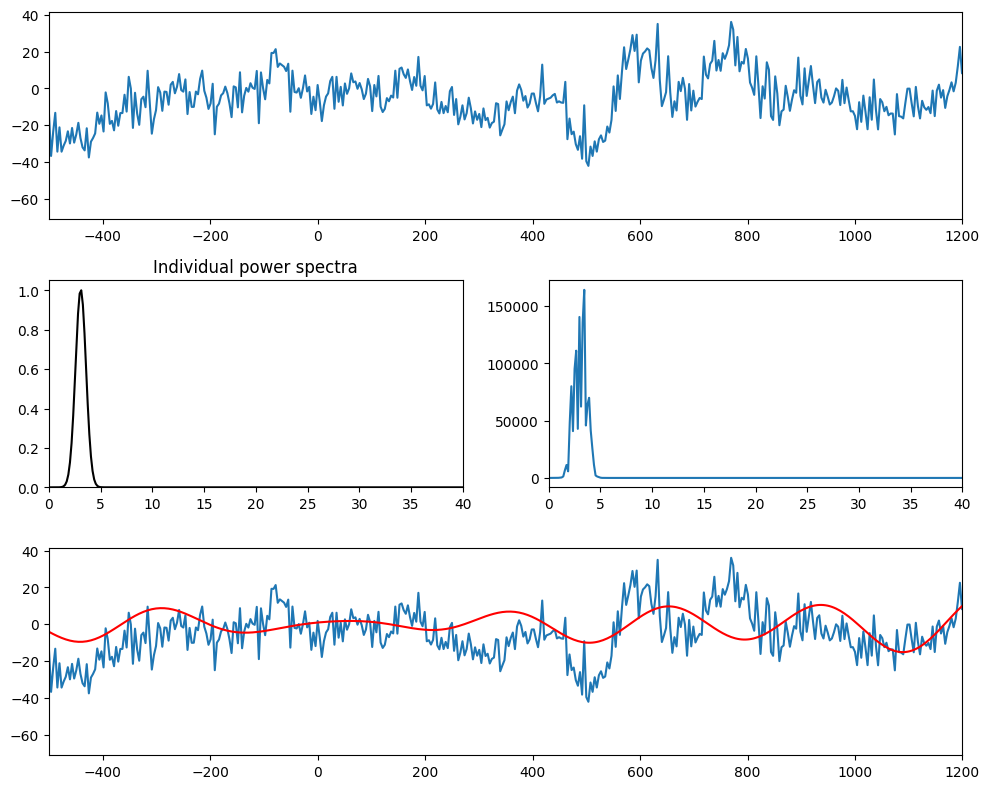

In [8]:
# Make a theta-band-centered wavelet
f = 6
s = 6 / (2 * np.pi * f)
wavelet = np.exp(2 * np.pi * 1j * f * time) * np.exp(-time**2 / (2 * s**2))
halfwaveletsize = int(np.ceil(len(wavelet) / 2))

eegdata = np.squeeze(EEG['data'][46,:,9])

plt.figure(figsize=(10, 8))

plt.subplot(311)
plt.plot(EEG['times'][0], eegdata)
plt.xlim([-500, 1200])

# Define n_conv and n2p1 for the FFT
n_conv = EEG['pnts'][0, 0] + len(time) - 1
n2p1 = n_conv // 2 + 1  # n2p1 = n/2 + 1

plt.subplot(323)
fft_w = fft(wavelet, n_conv)
hz = np.linspace(0, EEG['srate'][0, 0] / 2, n2p1)
plt.plot(hz, np.abs(fft_w[:n2p1]) / np.max(np.abs(fft_w[:n2p1])), 'k')
plt.xlim([0, 40])
plt.ylim([0, 1.05])
plt.title('Individual power spectra')

plt.subplot(324)
fft_e = fft(eegdata, n_conv)
plt.plot(hz, np.abs(fft_e[:n2p1]) * np.abs(fft_w[:n2p1]))
plt.xlim([0, 40])

plt.subplot(313)
plt.plot(EEG['times'][0], eegdata)
ift = ifft(fft_e * fft_w, n_conv) * np.sqrt(s) / 10
plt.plot(EEG['times'][0], np.real(ift[halfwaveletsize-1:-halfwaveletsize+1]), 'r')
plt.xlim([-500, 1200])

plt.tight_layout()
plt.show()

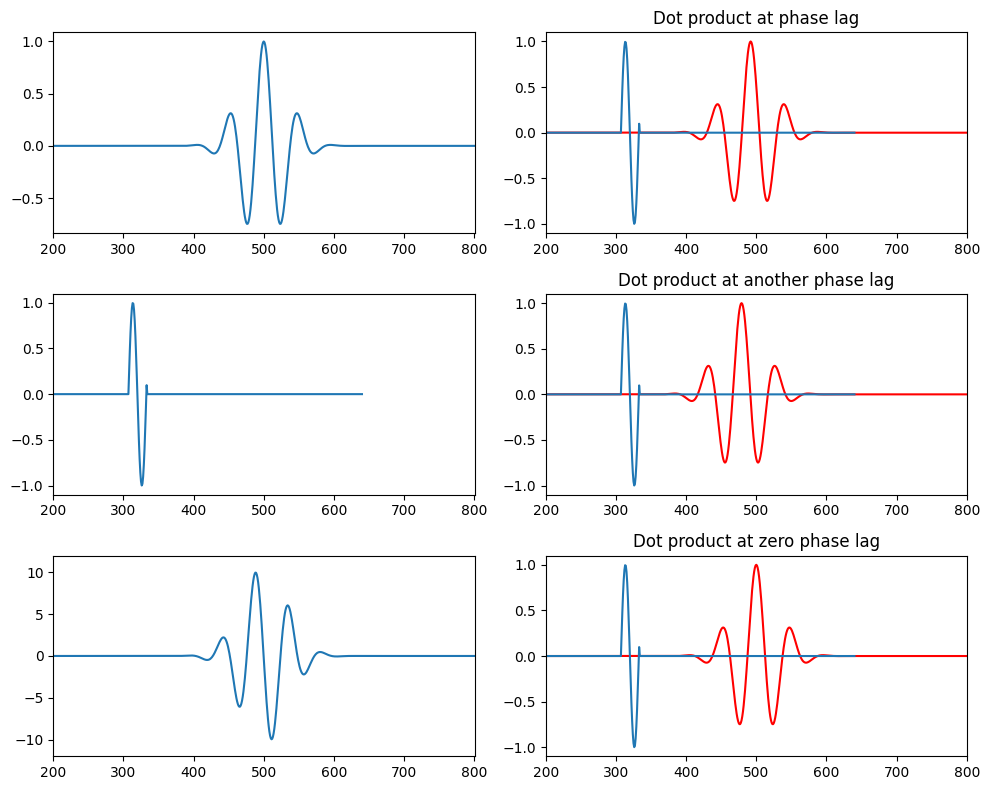

In [9]:
# Create 10 Hz wavelet (kernel)
f = 10  # frequency of sine wave in Hz
s = 4 / (2 * np.pi * f)
wavelet = np.cos(2 * np.pi * f * time) * np.exp(-time**2 / (2 * s**2))

# Signal is one sine cycle
timeS = np.arange(0, 1/f + 1/EEG['srate'][0, 0], 1/EEG['srate'][0, 0])
signal = np.sin(2 * np.pi * f * timeS)

# Zero-pad signal
signal = np.concatenate((np.zeros(EEG['pnts'][0, 0]//2 - len(timeS)//2), signal, np.zeros(EEG['pnts'][0, 0]//2 - len(timeS)//2)))

plt.figure(figsize=(10, 8))

# Plot wavelet
plt.subplot(321)
plt.plot(wavelet)
plt.xlim([200, len(time) - 200])

# Plot signal
plt.subplot(323)
plt.plot(signal)
plt.xlim([200, len(time) - 200])

# Plot convolution of wavelet and signal
plt.subplot(325)
plt.plot(np.convolve(wavelet, signal, 'same'))
plt.xlim([200, len(time) - 200])
plt.ylim([-12, 12])

# Plot dot products at selected phase lags
plt.subplot(322)
plt.plot(wavelet[round(100/f)-2:], 'r')
plt.plot(signal)
plt.xlim([200, len(time) - 200])
plt.title('Dot product at phase lag')

plt.subplot(324)
plt.plot(wavelet[round(2.3*(100/f)-2):], 'r')
plt.plot(signal)
plt.xlim([200, len(time) - 200])
plt.title('Dot product at another phase lag')

plt.subplot(326)
plt.plot(wavelet, 'r')
plt.plot(signal)
plt.xlim([200, len(time) - 200])
plt.title('Dot product at zero phase lag')

plt.tight_layout()
plt.show()